In [1]:
!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/


!pip install kneed
!pip install yellowbrick
!pip install pyclustering

!pip install tensorflow_text
!pip install --no-dependencies conversational-sentence-encoder

Cloning into 'MultiWOZ-Clustering'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 97 (delta 50), reused 78 (delta 31), pack-reused 0
Unpacking objects: 100% (97/97), done.
Checking out files: 100% (33/33), done.
     |████████████████████████████████| 2.6 MB 9.8 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=dd8f76b7cbdf1403727d605cf89b7353bd38a660a9e1f1da7bdf1fb3a96c8064
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering
     |████████████████████████████████| 4.9 MB 12.4 MB/s 
     |████████████████████████████████| 462 kB 64.3 MB/s 


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast
import nltk
import string 

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import tensorflow_hub as hub 
from scipy.spatial import distance
import tensorflow as tf

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn import metrics
from scipy.spatial.distance import cdist

from random import choices, sample

from conversational_sentence_encoder.vectorizers import SentenceEncoder

# Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping,  and kept them in a list(**cleaned_texts**) using clean()  
3. Then I embedded the utterances using "Universal Sentence Encoder"




# Functions

## Preprocessing functions

showing histogram of count of dialogues from services

In [3]:

import operator

def plot_services_from_dict(services_dict):
  services_count = {}
  
  for s in services_dict:
    services_count[s] = len(services_dict[s])

  sorted_services_count = sorted(services_count.items(), key=operator.itemgetter(1),  reverse=True)

  df_service_freq = pd.DataFrame(sorted_services_count, columns=['services', 'frequency'])


  df_service_freq.plot(kind='bar', x='services')

cleaning texts

In [4]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalnum()]
  #words = [w for w in words if not w in stop_words]
  
  stemmed_words = words
  #stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Embeddings


In [5]:
tf.compat.v1.disable_eager_execution()
sentence_encoder = SentenceEncoder(multiple_contexts=False)


def show_top_5_similar_embeddings(embeddings, cleaned_texts, test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]):
  """
  Description: prints top 5 simmilar utterances
  Params: 
    test_utterances: utterances to find top 5 simillar utterance of
    cleaned_texts: utterances
    embeddings: embeddings of all utterances
  """
  
  test_embeddings =  sentence_encoder.encode_sentences(test_utterances)

  similarity_matrix = []
  for idx in range(len(test_utterances)):
    similarity = {}
    for idx2 in range(len(embeddings)):
      similarity[1 - distance.cosine(test_embeddings[idx], embeddings[idx2])] = idx2
    similarity_matrix.append(similarity)


  for i in range(len(test_utterances)):
    scores = sorted(list(similarity_matrix[i].keys()))[-6:-1]
    print('Utterance:', test_utterances[i])
    print("Top 5: ")
    for s in scores:
      id = similarity_matrix[i][s]
      print(s, cleaned_texts[id])
    print()

## Clustering Functions

Histogram

In [6]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

 Find Similar Clusters

In [7]:
def find_similar_clusters(centers, threshold = 0.7,  clusters_to_check = None):
  '''
    Description:  Finds similarity between clusters and prints clusters which has clusters whose similarity score passes the threshold.

    Params:
      centers: centers of the clusters
      threshold: threshold to check
      clusters_to_check: [List] Give cluster numbers in list if you want to check for specific clusters. If not passed, all the clusters will be checked.
  '''
  if clusters_to_check is None:
    clusters_to_check = list(range(len(centers)))

  similarity_matrix = []
  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)

  for i in clusters_to_check:
    scores = list(similarity_matrix[i].keys())
    above_70 = list(filter(lambda score: score >= threshold, scores))
    if len(above_70) > 0:
      print(f"Clusters Similar with", i, ":")
      for s in above_70:
        id = similarity_matrix[i][s]
        print(id, s)
      print()

Print items from clusters

In [8]:
def print_cluster_items(clusters, cleaned_texts, num_of_items=5):
  for idx, cluster in enumerate(clusters):
    print(f"\n\nCluster No: {idx}\t Count: [{len(cluster)}]\n")
    
    if len(cluster) > num_of_items :
      for i in cluster[:num_of_items]:
        print(i, cleaned_texts[i])
    else:
      for i in cluster:
        print(i, cleaned_texts[i])

In [9]:
def save_nodes_with_n_utterances(speaker_prefix, n, clusters, cleaned_texts):
  nodes = {}
  for idx, cluster in enumerate(clusters):
      utterances = []
      if len(cluster) > n :
          for i in cluster[:n]:
            utterances.append(cleaned_texts[i])
      else:
          for i in cluster:
            utterances.append(cleaned_texts[i])      
      nodes[f"{speaker_prefix}-{idx}"] = utterances

  return nodes

Find Elbow Point

In [10]:
def findElbowPoint(embeddings, k, metric='distortion' ):
  '''
    metric: distortion/silhouette/calinski_harabasz
  '''
  model = KMeans()
  visualizer = KElbowVisualizer(model,k=k, metric=metric, timings=False)
  visualizer.fit(embeddings)        # Fit the data to the visualizer
  visualizer.show()  

Distortion

In [18]:
def distortion(embeddings, K):
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}


  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(embeddings)
      kmeanModel.fit(embeddings)
  
      distortions.append(sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / embeddings.shape[0])
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / embeddings.shape[0]
      mapping2[k] = kmeanModel.inertia_

  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()

Clustering

In [12]:
def xmeans_clustering(embeddings, number_of_clusters= 300):
  amount_initial_centers = 5

  initial_centers = kmeans_plusplus_initializer(embeddings, amount_initial_centers).initialize()
  
  # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
  # number of clusters that can be allocated is number_of_clusters.
  xmeans_instance = xmeans(embeddings, initial_centers, number_of_clusters)
  xmeans_instance.process()
  
  # Extract clustering results: clusters and their centers
  clusters = xmeans_instance.get_clusters()
  centers = xmeans_instance.get_centers()
  
  # Print total sum of metric errors
  print("Total WCE:", xmeans_instance.get_total_wce())
  
  #histogram
  show_hist(clusters, "xmeans")

  return clusters , centers



Clustering Clusters

In [13]:
def find_clusters(i, clusters_to_check, similarity_matrix, threshold):
  try:
      clusters_to_check.remove(i)
  except:
      pass



  i = int(i)
  scores = list(similarity_matrix[i].keys())
  above_70 = list(filter(lambda score: score >= threshold, scores))

  sim_clusters = [i]


  for cl in above_70:
    j = similarity_matrix[i][cl]

    sim_clusters.append(int(j))

    if j in clusters_to_check:
      result = find_clusters(j, clusters_to_check, similarity_matrix, threshold)

      sim_clusters += result 

  return set(sim_clusters)
  

In [14]:
def clustering_clusters(centers, clusters):

  similarity_matrix = []

  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)


  clusters_to_check = list(range(len(centers)))

  threshold = .8

  clustered_clusters = []

  while clusters_to_check:
    item = clusters_to_check.pop(0)

    result= find_clusters(item,clusters_to_check, similarity_matrix, threshold)
    clustered_clusters.append(result)
  
  clustered_clusters_combined = []

  for  clustered_clusters in clustered_clusters:
    clusters_combined = []
    for cluster_no in clustered_clusters:
      clusters_combined += clusters[cluster_no]
    clustered_clusters_combined.append(clusters_combined)

  return clustered_clusters_combined



# Pre Processing

### Sampling

Getting ids of services in service_id dictionary

In [ ]:
# path = "MultiWOZ-Clustering/train"
# file_list = os.listdir(path)

# services_id = {}

# for file in file_list:
#   with open(f'{path}/{file}') as f:
#     data = json.load(f)

#     for item in data:
#       dialogue_id = item["dialogue_id"]
#       service = " & ".join(item["services"])
#       if service in services_id:
#         services_id[service].append(dialogue_id)
#       else:
#         services_id[service] = [dialogue_id]

showing histogram of count of dialogues from services

In [ ]:
# plot_services_from_dict(services_id)

empty service = 357

multi-service = 5525

2+ services = 1496

3+ services = 34

3 services = 1462

sample k items from each of the services in sampled_services_id dict

In [ ]:

# """
#   choices: sampling with replacement(repetition)
#   sample: sampling without replacement(no repetition)
# """

# k = 200
# sampled_services_id = {}

# for service in services_id:
#   if len(services_id[service]) > 100:
#     sampled_services_id[service] = choices(services_id[service], k=k)


 distribution of dialogues count after sampling


In [ ]:
# plot_services_from_dict(sampled_services_id)

dictionary of ids for easy acessability

In [ ]:
# dialogue_ids_dict = {}
# for service in sampled_services_id:
#   for id in sampled_services_id[service]:
#     dialogue_ids_dict[id] = service


### Extracting texts from the sampled dialogues

In [ ]:
# path = "MultiWOZ-Clustering/train"
# file_list = os.listdir(path)

# dialogues = []

# for file in file_list:
#   with open(f'{path}/{file}') as f:

#     data = json.load(f)
#     for item in data:
#       dialogue_id = item["dialogue_id"]
#       if dialogue_id in dialogue_ids_dict:
#         utterance_count = len(item['turns'])
#         for idx, turn in enumerate(item['turns']):
#           next_utterance_id =  f'{idx+1}-{dialogue_id[:-5]}' if idx < utterance_count - 1 else ""

#           dialogues.append({
#               "dialogue_id" : dialogue_id[:-5],
#               "services": dialogue_ids_dict[dialogue_id],
#               "services_list" : item["services"],
#               "utterance_no": idx, 

#               "utterance_id" : f'{idx}-{dialogue_id[:-5]}', 
#               "next_utterance_id": next_utterance_id,
              
#               "speaker" : turn['speaker'],
#               "text" : turn['utterance'],
#               "cleaned_text" : clean(turn['utterance'])
#               })

# df = pd.DataFrame(dialogues)
# df.to_csv("dialogues_200_with_replacement.csv")
# df

# Using the same data of USE from repisotory 

In [15]:
df = pd.read_csv("/content/MultiWOZ-Clustering/dialogues_200_with_replacement.csv")
df.fillna('', inplace=True)
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,,SYSTEM,Have a wonderful day!,have a wonderful day
4,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,0-PMUL4452,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...
...,...,...,...,...,...,...,...,...,...,...
33319,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,15-MUL2568,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...
33320,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,16-MUL2568,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help
33321,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,17-MUL2568,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again
33322,33322,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",18,18-MUL2568,19-MUL2568,USER,Ok. Good bye!,ok good bye


# Clustering

## USER utterances only

* here I extracted and clustered only the utterances of USER. 

In [ ]:
cleaned_texts_user = list(df.loc[df['speaker'] == "USER", 'cleaned_text'])

embeddings_user = sentence_encoder.encode_sentences(cleaned_texts_user)

encoding sentence batches: 100%|██████████| 521/521 [04:45<00:00,  1.82it/s]


In [ ]:
test_utterances = choices(cleaned_texts_user, k = 20)

show_top_5_similar_embeddings(embeddings_user, cleaned_texts_user, test_utterances)

encoding sentence batches: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Utterance: yes that sounds great can you make reservations for that
Top 5: 
0.7781351208686829 that works great can you get us a reservation for 3 people
0.7827341556549072 yes that will be fine could you make a reservation for 3 at 1230 on saturday
0.7869369387626648 yes can you please make me a reservation
0.8303799033164978 sounds great can you set up a reservation
0.8359967470169067 yes that sounds fine i would like to book a reservation please

Utterance: i am leaving from cambridge going to broxbourne and want to arrive by 830
Top 5: 
0.840356707572937 i am departing from cambridge and going to broxbourne
0.8492137789726257 i am in broxbourne and need to travel to cambridge on friday
0.8541284203529358 i m leaving from london liverpool street and i need to arrive in cambridge by 0930
0.8598321676254272 i ll be leaving birmingham new street and going to cambridge i need to arrive by 0930
0.8677696585655212 i will be traveling to broxbourne on monday from cambridge and need to leav

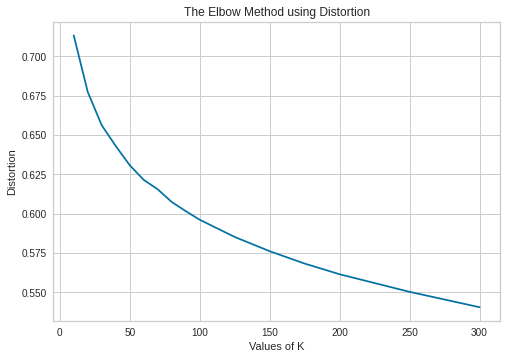

CPU times: user 1h 36min 28s, sys: 34min 16s, total: 2h 10min 44s
Wall time: 1h 7min 2s


In [ ]:
%%time
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200,250,300]

distortion(embeddings_user, k)

Total WCE: 5971.612233848878
Total Cluster: 125 
Total count of uttarance in Clusters:16662


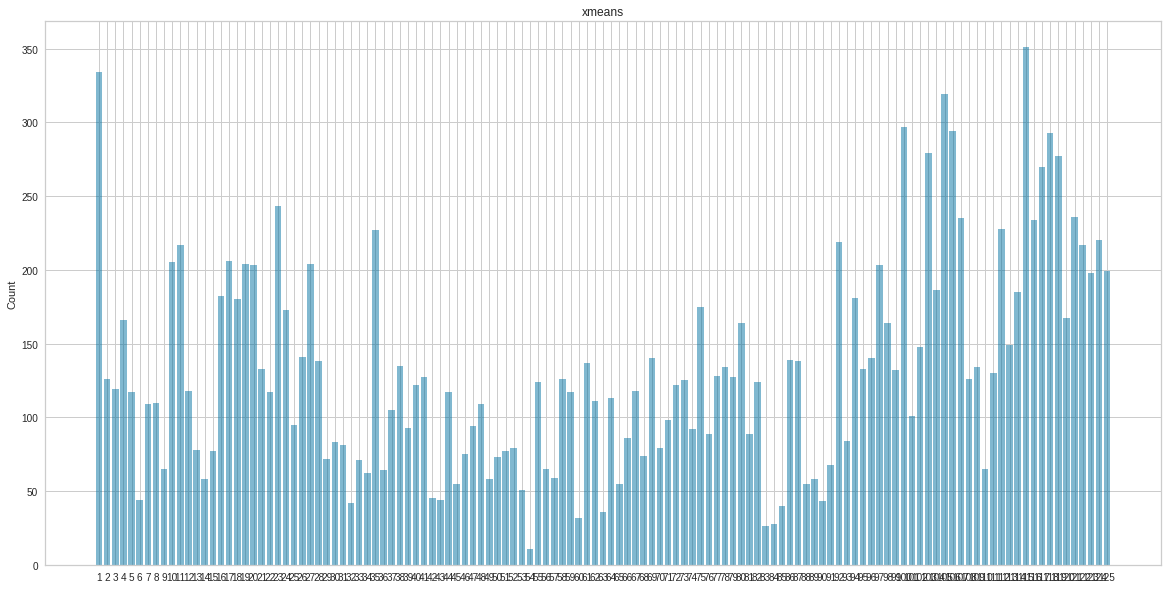

CPU times: user 1min 57s, sys: 384 ms, total: 1min 57s
Wall time: 1min 57s


In [ ]:
%%time
number_of_clusters = 125
clusters_user, centers_user = xmeans_clustering(embeddings_user, number_of_clusters)

In [ ]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_user, cleaned_texts_user, items_to_show_per_cluster)



Cluster No: 0	 Count: [334]

46 i would like to book a table on thursday for 6 people at 1330
71 yes please i need a table on friday at 1230 for 3 people please
111 sorry this is the husband im taking over the call my wife is too indecisive please book us for nandos at 1345 on tuesday for 5 people thank you
150 book the one in the centre a table for 2 at 1345 on thursday
361 can i reserve a table for two at the moderately priced indian restaurant
370 yes can you make a reservation for 2 people for wednesday at 1200 please thanks
405 sounds good can you book me a table for 6 on monday at 1100
431 could you just book a table for me i would like it to be on monday at 1730 for 3 people please
447 that s it can you make a reservation for me there are 5 of us and we would like to reserve sunday at 1145 if possible
621 yes please make a reservation for 6 people at 1000
667 yes please could you book a table for 7 at 1115 on thursday
713 ok thank you will you please reserve me a table for 6 p

In [ ]:
user_clusters_combined = clustering_clusters(centers_user, clusters_user)

user_text_clusters_id = {} #it will be used later

for idx, c in enumerate(user_clusters_combined):
  for i in c:
    user_text_clusters_id[cleaned_texts_user[i]] = f'u-{idx}'

# system utterances only

In [16]:
cleaned_texts_system = list(df.loc[df['speaker'] == "SYSTEM", 'cleaned_text'])

embeddings_system = sentence_encoder.encode_sentences(cleaned_texts_system)

encoding sentence batches: 100%|██████████| 521/521 [05:55<00:00,  1.47it/s]


In [ ]:
test_utterances = choices(cleaned_texts_system, k = 20)

show_top_5_similar_embeddings(embeddings_system, cleaned_texts_system, test_utterances)

encoding sentence batches: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Utterance: can i help you with anything else
Top 5: 
0.908099353313446 is there something else i can help you with
0.9098637700080872 can i help with anything more
0.9216556549072266 may i help you with any thing else
0.9411150217056274 can i help with anything else
0.9999999403953552 can i help you with anything else

Utterance: there are 16 available the one that is a beautiful place and is really inexpensive is the limehouse guesthouse do you need a room
Top 5: 
0.7028443217277527 we have 11 guesthouses and 2 hotels in the north area do you need a certain price range
0.7032783627510071 there are 9 cheap guesthouses that offer free parking i would recommend the alexander bed and breakfast due to being a 4 star place and offering guests free wifi
0.7049095630645752 i would recommend the autumn house it s a cheap guesthouse in the east that is 4 rated they offer free parking and wifi can i make you a reservation
0.706264317035675 there is 1 hotel and 9 guesthouses in the cheap price ra

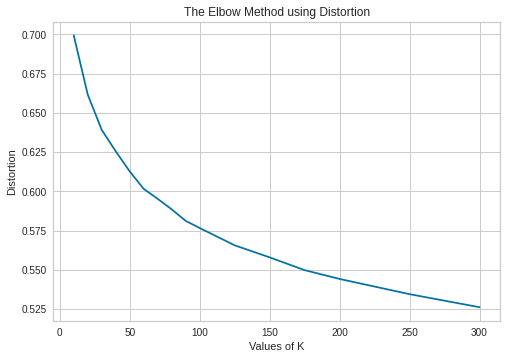

In [19]:
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200,250,300]

distortion(embeddings_system, k)

Total WCE: 5689.289578168961
Total Cluster: 125 
Total count of uttarance in Clusters:16662


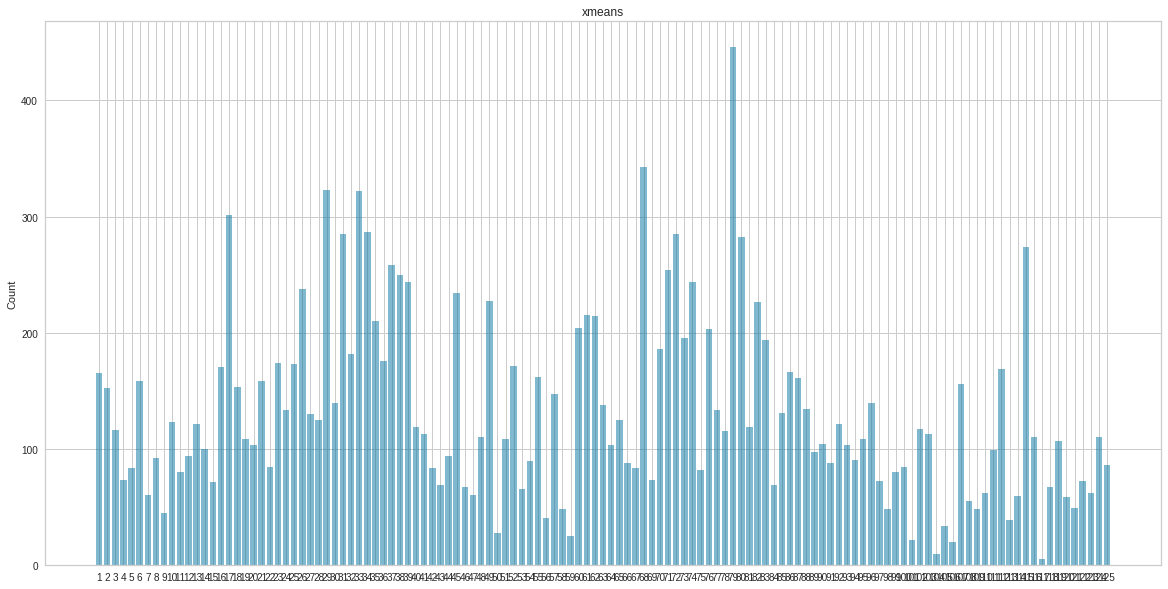

CPU times: user 1min 56s, sys: 300 ms, total: 1min 56s
Wall time: 1min 56s


In [ ]:
%%time
number_of_clusters = 125
clusters_system, centers_system = xmeans_clustering(embeddings_system, number_of_clusters)

In [ ]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_system, cleaned_texts_system, items_to_show_per_cluster)



Cluster No: 0	 Count: [165]

15 what time would you like to arrive at castle galleries
19 absolutely do you have a particular arrival or departure time in mind today
49 when are you wanting to arrive
230 sure when would you like to arrive
301 no problem i just need to know what time you wish to get there and where you ll be arriving from
554 yes but i need the day that you will be arriving first
650 i can do that i just need to know what time you want to leave or arrive
670 what time would you like to arrive in cambridge
744 what time do you need to be picked up and from where
762 sure when would you like to arrive
828 okay i need to know when you would like to leave the hotel and when you d like to arrive at the museum please
860 sure are you wanting to depart from club salsa when do you want to arrive by
913 i will need a time before i can book
1048 sure when would you like to depart
1064 alright i ll first need to know a time for the booking as well as a pickup location please
110

In [ ]:
system_clusters_combined = clustering_clusters(centers_system, clusters_system )


system_text_clusters_id = {}

for idx, c in enumerate(system_clusters_combined):
  for i in c:
    system_text_clusters_id[cleaned_texts_system[i]] = f's-{idx}'



Creating df of Nodes

In [ ]:
user_nodes = save_nodes_with_n_utterances("u", 10, user_clusters_combined, cleaned_texts_user)

system_nodes = save_nodes_with_n_utterances("s", 10, system_clusters_combined, cleaned_texts_system)

In [ ]:
nodes = {**user_nodes , **system_nodes}


In [ ]:
nodes_df = pd.Series(nodes).to_frame('utterenaces')
#nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
#nodes_df = nodes_df.T
nodes_df.to_csv("nodes_convRT_with_10_utterances.csv")
nodes_df

,utterenaces
u-0,[i would like to book a table on thursday for ...
u-1,[not really can you book one of them for frida...
u-2,"[just one what is the price to book the train,..."
u-3,"[yeah can you get me a ticket, yes i ll need 4..."
u-4,"[just one please, yes please for 6 people, oh ..."
u-5,"[yes please for 2 nights, what about 3 nights,..."
u-6,[i just need it to be cheap and available on t...
u-7,"[i m coming from norwich, i will be leaving fr..."
u-8,"[that was all thanks, nothing more thank you, ..."
u-9,"[nope that s it thanks, no that would be it th..."


# Getting Clusters and Edges

In [ ]:
def get_cluste_id(text, speaker):

  if speaker == "USER":
    return user_text_clusters_id[text] if text in user_text_clusters_id else "User No Cluster"   

  elif speaker == "SYSTEM":
    return system_text_clusters_id[text] if text in system_text_clusters_id else "System No Cluster"

In [ ]:
df["cluster_id"] = df.apply(lambda x: get_cluste_id(x['cleaned_text'].strip(),  x['speaker']) , axis=1)

In [ ]:
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text,cluster_id
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-26
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-0
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-8
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,,SYSTEM,Have a wonderful day!,have a wonderful day,s-24
4,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,0-PMUL4452,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...,u-7
...,...,...,...,...,...,...,...,...,...,...,...
33319,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,15-MUL2568,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...,s-0
33320,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,16-MUL2568,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help,u-8
33321,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,17-MUL2568,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again,s-15
33322,33322,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",18,18-MUL2568,19-MUL2568,USER,Ok. Good bye!,ok good bye,u-8


In [ ]:
df = df.set_index('utterance_id')

In [ ]:
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,next_utterance_id,speaker,text,cleaned_text,cluster_id
utterance_id,,,,,,,,,,
0-SNG02022,0,SNG02022,hospital,['hospital'],0,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-26
1-SNG02022,1,SNG02022,hospital,['hospital'],1,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-0
2-SNG02022,2,SNG02022,hospital,['hospital'],2,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-8
3-SNG02022,3,SNG02022,hospital,['hospital'],3,,SYSTEM,Have a wonderful day!,have a wonderful day,s-24
0-PMUL4452,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...,u-7
...,...,...,...,...,...,...,...,...,...,...
15-MUL2568,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...,s-0
16-MUL2568,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help,u-8
17-MUL2568,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again,s-15


In [ ]:
df["next_utterance_cluster_id"] = df.apply(lambda x: df.loc[x['next_utterance_id']]["cluster_id"] if x['next_utterance_id'] != "" else None,  axis=1)

In [ ]:
df.to_csv("dialogue_clusters_convRT_200_with_replacement.csv")

In [ ]:
df_edges = df[["cluster_id", "next_utterance_cluster_id"]]
df_edges = df_edges.dropna()
df_edges.columns = ['Source', 'Target']

df_edges

,Source,Target
utterance_id,,
0-SNG02022,u-26,s-0
1-SNG02022,s-0,u-8
2-SNG02022,u-8,s-24
0-PMUL4452,u-7,s-0
1-PMUL4452,s-0,u-7
...,...,...
14-MUL2568,u-7,s-0
15-MUL2568,s-0,u-8
16-MUL2568,u-8,s-15


In [ ]:
df_edges.to_csv("edges_convRT_200_with_replacement.csv")

In [ ]:
df_edges_weights = df_edges.groupby(['Source','Target']).size().reset_index().rename(columns={0:'Weight'})
df_edges_weights


,Source,Target,Weight
0,s-0,u-0,1769
1,s-0,u-1,137
2,s-0,u-10,44
3,s-0,u-11,54
4,s-0,u-12,78
...,...,...,...
473,u-9,s-23,2
474,u-9,s-24,50
475,u-9,s-25,1
476,u-9,s-27,10


In [ ]:
df_edges_weights.to_csv("edges_weight_convRT_200_with_replacement.csv")